In [2]:
import pandas as pd
import numpy as np
import sklearn
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
import math
import sys
import os
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
device = torch.device("cuda:0")

In [4]:
inDF = pd.read_csv('../inputData/87_GN2_4j.csv')
inDF.shape
#inDF.loc[ inDF['higgs_pt'] <= 250000, 'higgs_pt'] = 0
#inDF.loc[ inDF['higgs_pt'] > 250000, 'higgs_pt'] = 1
#pd_train, pd_test = train_test_split(inDF, test_size=0.3)

(71867, 37)

In [6]:
newDF = pd.read_csv('../inputData/87_GN2.csv')
newDF.shape

(1785072, 24)

In [3]:
y_test = pd_test['higgs_pt']
y_train = pd_train['higgs_pt']
pd_train = pd_train.drop(['higgs_pt'],axis=1)                                                                                                         
pd_test = pd_test.drop(['higgs_pt'],axis=1) 

NameError: name 'pd_test' is not defined

In [8]:
inDF

,Unnamed: 0,DRjj01,DRlj00,DRll01,HT,MET,MET_phi,Mll01,Ptll01,higgs_pt,...,jet_Pt_1,jet_Pt_2,jet_Pt_3,lep_E_0,lep_E_1,lep_Eta_0,lep_Eta_1,lep_Phi_1,lep_Pt_0,lep_Pt_1
0,0,0.452937,3.122995,2.322022,1.283018e+06,78470.734375,-0.822769,238532.437500,587104.375000,333338.189446,...,237875.140625,75402.976562,47910.230469,631869.250000,27644.185547,-0.318361,0.463143,-2.186558,601146.812500,24923.046875
1,1,2.965169,3.004903,0.709195,5.921901e+05,14616.681641,2.878256,40670.179688,118132.265625,120771.748780,...,128162.601562,126485.476562,62605.636719,80105.828125,59553.273438,-0.241580,-0.927111,0.181671,77823.757812,40749.472656
2,2,3.939633,2.330488,1.692138,6.715475e+05,72313.476562,1.757585,56580.851562,52988.574219,61004.383154,...,119277.968750,107666.382812,85639.625000,75426.726562,35917.941406,-1.287918,-0.450481,1.470384,38669.656250,32558.126953
3,3,2.270463,2.965903,3.211834,3.993049e+05,79743.750000,-0.462884,59570.992188,11926.413086,144478.668779,...,91893.312500,64264.542969,51273.992188,34789.941406,27078.251953,0.086952,-0.608781,-3.135576,34658.835938,22733.619141
4,4,2.308447,1.464446,1.691607,4.614077e+05,17899.662109,-0.036992,44762.382812,43280.914062,53300.464921,...,63882.195312,54419.894531,53094.699219,89240.789062,36607.187500,1.480240,1.071013,1.641362,38619.121094,22451.443359
5,5,2.204209,1.949713,1.851815,5.165403e+05,60257.046875,-1.749193,63659.675781,62524.816406,45264.640402,...,94237.289062,70117.351562,39911.136719,79861.656250,101557.195312,0.943899,2.201269,1.359499,53977.128906,22205.234375
6,6,1.522827,1.586790,1.501815,3.675219e+05,102825.734375,1.658754,36160.578125,43321.449219,148679.082211,...,82807.421875,42660.585938,42144.816406,35939.820312,118385.242188,0.990568,2.388993,0.547590,23458.421875,21535.869141
7,7,2.886809,2.229897,2.962825,4.406600e+05,18560.289062,2.003855,121581.171875,86227.445312,166275.635054,...,77162.656250,50358.285156,28716.853516,117188.046875,31888.890625,0.067268,-0.166703,-2.953572,116923.406250,31450.871094
8,8,1.278631,2.942235,0.306701,7.603308e+05,53794.667969,-3.098555,30694.214844,203818.187500,309799.071766,...,78950.414062,73044.929688,69485.304688,387198.531250,277834.031250,1.791952,1.914191,0.281289,125554.984375,80195.601562
9,9,1.798802,2.024251,0.795250,4.102850e+05,55492.628906,0.256030,31775.638672,79843.921875,128856.275804,...,68929.546875,50672.886719,41475.406250,60072.765625,34556.058594,0.400542,0.529861,-0.784665,55556.214844,30214.496094


In [7]:
newDF

,is2LSS0Tau,DRlj00,DRjj01,higgs_pt,MET_RefFinal_et,MET_RefFinal_phi,lep_Pt_0,lep_Eta_0,lep_Phi_0,lep_Pt_1,...,DRll01,nJets_OR_T,nJets_OR_T_MV2c10_70,HT,lead_jetPt,lead_jetEta,lead_jetPhi,sublead_jetPt,sublead_jetEta,sublead_jetPhi
0,1,3.609838,3.105733,88760.824341,39020.136719,0.563558,65184.871094,1.329590,2.048432,34500.503906,...,2.833694,6,2,5.954336e+05,128011.968750,-0.647730,-1.214631,98597.164062,0.446993,2.162155
1,1,0.414457,1.602660,43611.796922,42094.937500,2.380833,40491.316406,-0.417551,-0.656650,33267.363281,...,2.171907,5,1,2.995526e+05,68017.406250,-0.154631,-0.977037,42586.082031,0.199837,0.585931
2,1,3.105180,3.002820,86401.727659,38622.136719,2.870437,80014.031250,0.043774,-1.974631,30102.220703,...,2.189412,4,1,3.467398e+05,126511.656250,-0.360810,1.104078,47005.578125,1.583032,-1.184678
3,1,3.048877,2.777426,269912.810945,105897.687500,2.907982,136328.765625,2.151827,-3.129472,36312.937500,...,1.188575,6,1,7.036106e+05,159294.390625,0.436747,0.632969,123345.367188,2.041372,-1.634027
4,1,2.741835,2.378973,31981.571744,71650.296875,2.752498,35063.796875,1.323761,3.133612,21472.625000,...,2.389086,5,1,4.099527e+05,138765.578125,1.302619,0.391858,85941.804688,0.819658,-1.937576
5,1,1.656937,2.747498,78554.450423,18787.943359,-1.253867,45864.238281,1.913489,-1.647332,37818.144531,...,0.472404,7,1,6.271243e+05,176302.593750,2.090300,0.000144,157836.390625,1.703135,2.720226
6,1,2.249664,1.226856,244595.457256,34476.652344,0.305989,74342.929688,-0.711942,0.741606,48178.867188,...,0.717594,6,2,5.613458e+05,128014.843750,-0.021048,-1.399341,116665.781250,-0.569402,-2.496830
7,1,2.727442,2.305941,89950.519083,30559.306641,-2.320583,55662.718750,-0.695895,-1.436637,22430.468750,...,3.316627,5,2,3.294393e+05,82168.867188,-0.728620,1.290609,66796.031250,0.367501,-2.963813
8,1,2.487892,3.170909,49101.286610,14944.644531,1.403479,63679.406250,-1.092867,1.702056,44032.640625,...,2.160175,6,1,6.048059e+05,150844.656250,-0.234015,-2.246181,145224.203125,-0.982785,0.955770
9,1,3.899584,1.205337,164237.442164,23719.318359,2.373002,106623.929688,1.760181,3.045357,21234.554688,...,2.056099,7,2,5.860047e+05,89204.890625,-0.974941,0.265814,87279.679688,-0.191961,-0.650580


In [13]:
newDF[newDF.duplicated()==0]

,is2LSS0Tau,DRlj00,DRjj01,higgs_pt,MET_RefFinal_et,MET_RefFinal_phi,lep_Pt_0,lep_Eta_0,lep_Phi_0,lep_Pt_1,...,DRll01,nJets_OR_T,nJets_OR_T_MV2c10_70,HT,lead_jetPt,lead_jetEta,lead_jetPhi,sublead_jetPt,sublead_jetEta,sublead_jetPhi
0,1,3.609838,3.105733,88760.824341,39020.136719,0.563558,65184.871094,1.329590,2.048432,34500.503906,...,2.833694,6,2,5.954336e+05,128011.968750,-0.647730,-1.214631,98597.164062,0.446993,2.162155
1,1,0.414457,1.602660,43611.796922,42094.937500,2.380833,40491.316406,-0.417551,-0.656650,33267.363281,...,2.171907,5,1,2.995526e+05,68017.406250,-0.154631,-0.977037,42586.082031,0.199837,0.585931
2,1,3.105180,3.002820,86401.727659,38622.136719,2.870437,80014.031250,0.043774,-1.974631,30102.220703,...,2.189412,4,1,3.467398e+05,126511.656250,-0.360810,1.104078,47005.578125,1.583032,-1.184678
3,1,3.048877,2.777426,269912.810945,105897.687500,2.907982,136328.765625,2.151827,-3.129472,36312.937500,...,1.188575,6,1,7.036106e+05,159294.390625,0.436747,0.632969,123345.367188,2.041372,-1.634027
4,1,2.741835,2.378973,31981.571744,71650.296875,2.752498,35063.796875,1.323761,3.133612,21472.625000,...,2.389086,5,1,4.099527e+05,138765.578125,1.302619,0.391858,85941.804688,0.819658,-1.937576
5,1,1.656937,2.747498,78554.450423,18787.943359,-1.253867,45864.238281,1.913489,-1.647332,37818.144531,...,0.472404,7,1,6.271243e+05,176302.593750,2.090300,0.000144,157836.390625,1.703135,2.720226
6,1,2.249664,1.226856,244595.457256,34476.652344,0.305989,74342.929688,-0.711942,0.741606,48178.867188,...,0.717594,6,2,5.613458e+05,128014.843750,-0.021048,-1.399341,116665.781250,-0.569402,-2.496830
7,1,2.727442,2.305941,89950.519083,30559.306641,-2.320583,55662.718750,-0.695895,-1.436637,22430.468750,...,3.316627,5,2,3.294393e+05,82168.867188,-0.728620,1.290609,66796.031250,0.367501,-2.963813
8,1,2.487892,3.170909,49101.286610,14944.644531,1.403479,63679.406250,-1.092867,1.702056,44032.640625,...,2.160175,6,1,6.048059e+05,150844.656250,-0.234015,-2.246181,145224.203125,-0.982785,0.955770
9,1,3.899584,1.205337,164237.442164,23719.318359,2.373002,106623.929688,1.760181,3.045357,21234.554688,...,2.056099,7,2,5.860047e+05,89204.890625,-0.974941,0.265814,87279.679688,-0.191961,-0.650580


In [99]:
#Convert data to tensors
x_train = torch.tensor(pd_train.values, dtype=torch.float32)
x_test = torch.tensor(pd_test.values, dtype=torch.float32)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [131]:
print(y_test.max())

tensor(1255844.6250)


In [100]:
X = x_train
Y = y_train

X_test = x_test
Y_test = y_test

In [101]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed

In [102]:
X = normalize(X)
Y = normalize(Y)

X_test = normalize(X_test)
Y_test = normalize(Y_test)

In [103]:
class OldNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
oldNet = OldNet()
#opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [104]:
class Net(nn.Module):
    
    def __init__(self, D_in, nodes, layers):
        self.layers = layers
        super().__init__()
        self.fc1 = nn.Linear(D_in, nodes)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        #self.fc2 = nn.Linear(50, 100)
        self.fc = nn.Linear(nodes, nodes)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(nodes, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        h1 = self.dout(self.relu1(self.fc1(input_)))
        for i in range(self.layers):
            h1 = self.dout(self.relu1(self.fc(h1)))
        a1 = self.out(h1)
        y = self.out_act(a1)
        return y

In [105]:

def train_epoch(model, opt, criterion, batch_size=10000):
    model.train()
    losses = []

    opt.zero_grad()
    # (1) Forward
    y_hat = net(X)
    # (2) Compute diff
    loss = criterion(y_hat[:,0], Y)
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())
    
    return loss, y_hat[:,0]

In [106]:
class param:
    def __init__(self, epochs, layers, nodes, auc = 0, loss = 1):
        self.epochs = epochs
        self.layers = layers
        self.nodes = nodes
        self.auc = auc
        self.train_loss = None
        self.test_loss = None
        self.y_pred = None
        self.y_pred_test = None
        self.net = None
    

In [107]:
num_epochs = [4000]
nLayers = [4, 6, 8, 12]
nNodes = [75, 150, 250]

param_grid = []
for ep in num_epochs:
    for la in nLayers:
        for node in nNodes:
            param_grid.append(param(ep, la, node))

In [54]:
def scale_pt(y_predicted):
    y_pred_scaled = (y_predicted-y_predicted.min())/(y_predicted.max()-y_predicted.min())
    return y_pred_scaled

In [108]:
last_p = [param_grid[4]]
#for p in param_grid:
for p in last_p:
    net = Net(pd_train.shape[1], p.nodes, p.layers)
    opt = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))
    criterion = nn.L1Loss()
    y_pred = []
    y_test_pred=[]
    e_losses = []
    test_losses = []
    
    for e in range(p.epochs):
        e_loss, y_pred = train_epoch(net, opt, criterion) 
        #e_losses.append(loss)
        if e%100==0:
            y_pred_test = net(X_test)[:,0]
            test_loss = criterion(y_pred_test, Y_test).float().detach().numpy()
            test_losses.append(test_loss)
            print("[Epoch]: %i, [Train Loss]: %.4f, [Test Loss]: %.4f" % (e, e_loss, test_loss))
            if e>300 and test_losses[-2]-test_losses[-1]<10e-8: 
                p.epochs=e
                break
    
    p.net = net
    p.train_loss = e_loss.float().detach().numpy()
    p.test_loss = test_loss
    p.y_pred_test = y_pred_test.float().detach().numpy()
    p.y_pred = y_pred.float().detach().numpy()
    #p.auc = sk.metrics.roc_auc_score(y_train,y_predicted)
    
    print("Nodes: "+str(p.nodes))
    print("Layers: "+str(p.layers))
    print("Train Loss: "+str(p.train_loss))
    print("Test Loss: "+str(p.test_loss))
    print("")
    
    del net, opt, criterion, y_pred, y_pred_test

[Epoch]: 0, [Train Loss]: 0.4160, [Test Loss]: 0.4042
[Epoch]: 100, [Train Loss]: 0.0620, [Test Loss]: 0.0717
[Epoch]: 200, [Train Loss]: 0.0507, [Test Loss]: 0.0574
[Epoch]: 300, [Train Loss]: 0.0498, [Test Loss]: 0.0565
[Epoch]: 400, [Train Loss]: 0.0489, [Test Loss]: 0.0557
[Epoch]: 500, [Train Loss]: 0.0481, [Test Loss]: 0.0545
[Epoch]: 600, [Train Loss]: 0.0470, [Test Loss]: 0.0534
[Epoch]: 700, [Train Loss]: 0.0460, [Test Loss]: 0.0522
[Epoch]: 800, [Train Loss]: 0.0453, [Test Loss]: 0.0513
[Epoch]: 900, [Train Loss]: 0.0446, [Test Loss]: 0.0503
[Epoch]: 1000, [Train Loss]: 0.0437, [Test Loss]: 0.0493
[Epoch]: 1100, [Train Loss]: 0.0429, [Test Loss]: 0.0484
[Epoch]: 1200, [Train Loss]: 0.0423, [Test Loss]: 0.0479
[Epoch]: 1300, [Train Loss]: 0.0416, [Test Loss]: 0.0472
[Epoch]: 1400, [Train Loss]: 0.0413, [Test Loss]: 0.0468
[Epoch]: 1500, [Train Loss]: 0.0410, [Test Loss]: 0.0466
[Epoch]: 1600, [Train Loss]: 0.0408, [Test Loss]: 0.0463
[Epoch]: 1700, [Train Loss]: 0.0406, [Test 

In [21]:
param_grid[2].y_pred

array([0.12140456, 0.0939497 , 0.09836164, ..., 0.05742204, 0.07746226,
       0.02158123], dtype=float32)

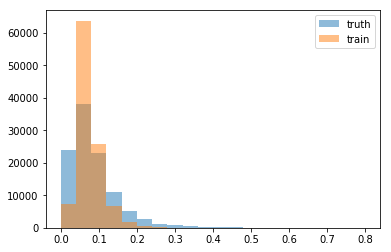

In [59]:
plt.hist(Y, 20, log=False, range=(0, 0.8), alpha=0.5, label='truth')
plt.hist(param_grid[5].y_pred, 20, log=False, range=(0, 0.8), alpha=0.5, label='train')
plt.legend(loc='upper right')
plt.show()

TypeError: '>=' not supported between instances of 'NoneType' and 'float'

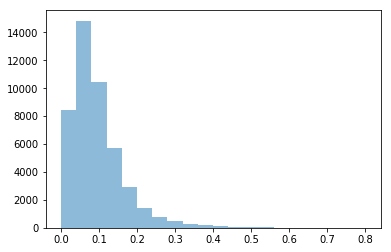

In [110]:
plt.hist(Y_test, 20, log=False, range=(0, 0.8), alpha=0.5, label='truth')
plt.hist(param_grid[2].y_pred_test,20, log=False, range=(0, 0.8), alpha=0.5, label='test')
plt.legend(loc='upper right')
plt.show()

In [130]:
torch.save(param_grid[4].net,'net.pt')

/usr/lib64/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


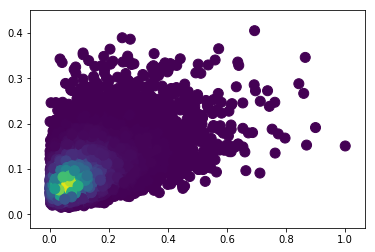

In [115]:
# Calculate the point density
xy = np.vstack([Y_test, param_grid[4].y_pred_test])
z = scipy.stats.gaussian_kde(xy)(xy)

Text(0,0.5,'Predicted Pt')

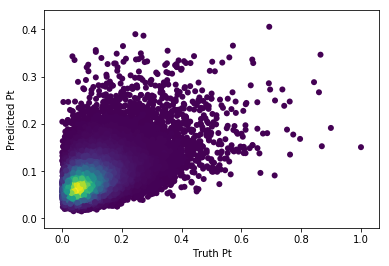

In [128]:
plt.figure()
plt.scatter(Y_test, param_grid[4].y_pred_test, c=z, edgecolor='')
plt.xlabel('Truth Pt')
plt.ylabel('Predicted Pt')

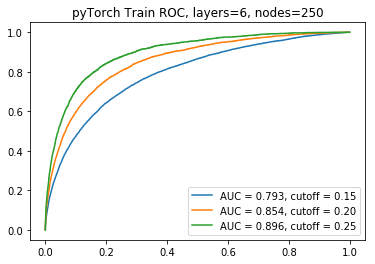

In [60]:
#y_predicted = y_pred.float().detach().numpy()
cutoff = [0.15, 0.2, 0.25]

plt.figure()
for c in cutoff:
    yTrain = np.where(Y > c, 1, 0)
    ypTrain = param_grid[5].y_pred

    auc = sk.metrics.roc_auc_score(yTrain,ypTrain)
    fpr, tpr, _ = sk.metrics.roc_curve(yTrain,ypTrain)

    plt.plot(fpr, tpr, label='AUC = %.3f, cutoff = %0.2f' %(auc, c))

plt.title("pyTorch Train ROC, layers=%i, nodes=%i" %(param_grid[5].layers, param_grid[5].nodes))
plt.legend(loc='lower right')    
plt.show()

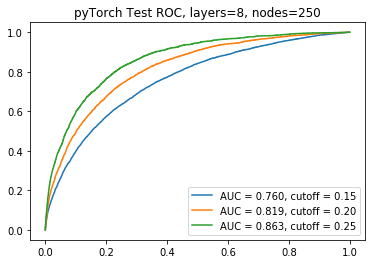

In [61]:
#y_predicted = y_pred.float().detach().numpy()
cutoff = [0.15, 0.2, 0.25]

plt.figure()
for c in cutoff:
    yTest = np.where(Y_test > c, 1, 0)
    ypTest = param_grid[8].y_pred_test

    auc = sk.metrics.roc_auc_score(yTest,ypTest)
    fpr, tpr, _ = sk.metrics.roc_curve(yTest,ypTest)

    plt.plot(fpr, tpr, label='AUC = %.3f, cutoff = %0.2f' %(auc, c))

plt.title("pyTorch Test ROC, layers=%i, nodes=%i" %(param_grid[8].layers, param_grid[8].nodes))
plt.legend(loc='lower right')    
plt.show()

Predict on test sample

In [ ]:
x_test, y_test = Variable(x_test, volatile=True), Variable(y_test)

In [ ]:
#y_pred_test = y_pred_test.detach().numpy()
auc = sk.metrics.roc_auc_score(y_test,y_pred_test)

roc_array = sk.metrics.roc_curve(y_test,y_pred_test)

plt.figure()
plt.plot(roc_array[1], label='AUC = '+str(auc))
plt.title("pytorch test ROC")
plt.legend(loc='lower right')

[[array(0.04884519, dtype=float32), array(0.04902332, dtype=float32), array(0.0491308, dtype=float32), array(0.04975073, dtype=float32)], [array(0.0502816, dtype=float32), array(0.05093752, dtype=float32), array(0.05059234, dtype=float32), array(0.05218538, dtype=float32)], [array(0.04891586, dtype=float32), array(0.04998652, dtype=float32), array(0.04955451, dtype=float32), array(0.04973552, dtype=float32)]]


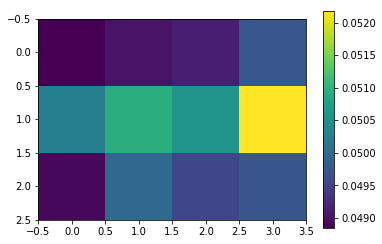

In [83]:
def extents(f):
    delta=f[1]-f[0]
    return [f[0]-delta/2, f[-1]+delta/2]

l_list = [x.layers for x in param_grid]
l_list = list(set(l_list))
n_list = [x.nodes for x in param_grid]
n_list = list(set(n_list))

t_list = []
for n in n_list:
    tmp_list = []
    for p in param_grid:
        if p.nodes==n:
            tmp_list.append(p.test_loss)
    t_list.append(tmp_list)

print(t_list)
plt.imshow(t_list)
plt.colorbar()
plt.show()

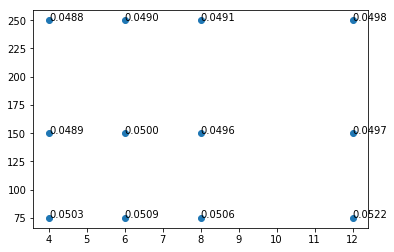

In [94]:
l_vals,n_vals,t_vals = zip(*[(i.layers, i.nodes, i.test_loss) for i in param_grid])
plt.scatter(l_vals,n_vals)#, c=t_vals)
#plt.colorbar()
for i, txt in enumerate(t_vals):
    plt.annotate("%0.4f" %(txt), (l_vals[i],n_vals[i]))